# Import libraries

In [1]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

2024-09-17 20:50:59.610252: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-17 20:50:59.613008: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-17 20:50:59.621118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 20:50:59.636957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 20:50:59.636981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 20:50:59.647806: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [3]:
dict = parse_variables('geno_simulation.txt')
G = 10
L = 100
c = 50
k = 2
M = .1
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, complete = simulate_genos(G, L, c, k, M, HWE)

In [4]:
humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop
humans['populations'] = humans['populations'].apply(lambda x: 1 if x in [1, 2] else 2)

In [5]:
true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(complete, humans)

In [6]:
number_of_individuals = c*k*k

In [7]:
count_total_AFs = complete.apply(pd.Series.value_counts).fillna(0)/number_of_individuals

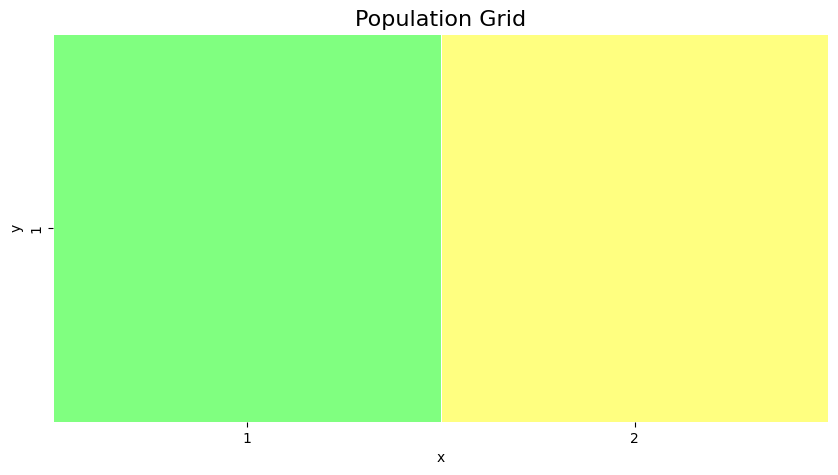

In [8]:
first_snp = list(complete.columns)[0]
geno = complete[[first_snp]]
p2_min_q2 = true_p2s - true_q2s
p2_min_q2 = p2_min_q2[[first_snp]]
populations = humans[['populations']]
populations['x'] = populations['populations']
populations['y'] = 1
populations['z'] = 0.5
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

In [9]:
scaler = StandardScaler()
scaled_complete = scaler.fit_transform(complete)
n_components = max(min(complete.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_complete = pca.fit_transform(scaled_complete)
PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

In [10]:
to_have_collumns = ['populations', 'x', 'y']
PC_complete[to_have_collumns] = populations[to_have_collumns]

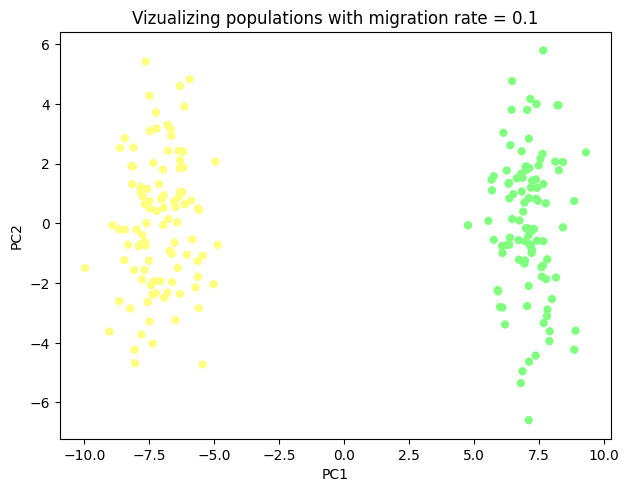

In [11]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [12]:
PC_complete['mafs'] = true_q2s[[first_snp]].apply(np.sqrt).round(2)

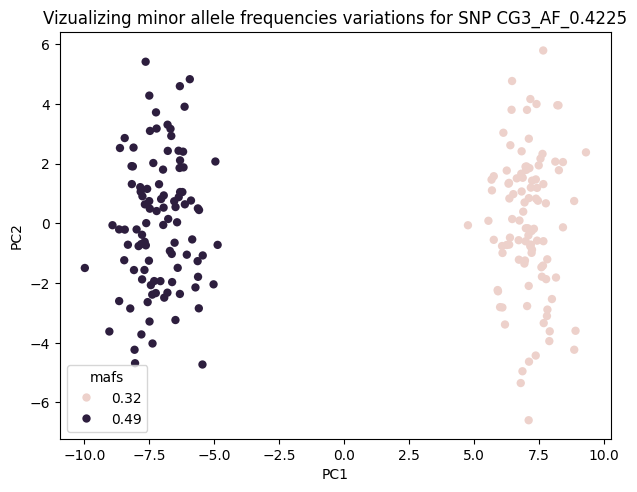

In [13]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mafs', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing minor allele frequencies variations for SNP {first_snp}")
plt.show()
plt.close()

In [14]:
risk = existing_risks[1]
risk

'NW_risk_fun'

In [15]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

In [16]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
populations['x_temp'] = populations['x']/k
populations['y_temp'] = populations['y']/k
populations[name_risk] = list(populations.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
populations[name_risk] = populations[name_risk].astype('float')

In [17]:
PC_complete['risk'] = populations['NW_risk']
humans['risk'] = populations['NW_risk']

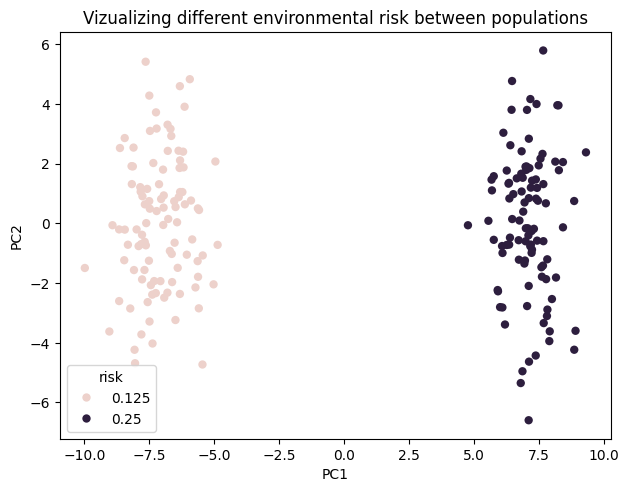

In [18]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'risk', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different environmental risk between populations")
plt.show()
plt.close()

# Manually comparing the betas

In [19]:
def manual_ols(X,y):
    X = np.array(complete[[first_snp]])
    #X = np.column_stack([np.ones(len(X)), X])
    beta_matrix = np.linalg.inv(X.T @ X)
    y = np.array(y).reshape(-1, 1)  # Reshape to 2D column vector
    beta_matrix = (beta_matrix @ X.T) @ y
    return beta_matrix[0][0]

In [20]:
scaler = StandardScaler()
humans['risk'] = scaler.fit_transform(humans[['risk']])

In [21]:
def min_max_scaling(X,min_val,max_val):
    X = np.array(X)
    X_min = np.min(X)
    X_max = np.max(X)
    
    # If the column has constant values (min == max), return the original values unscaled
    if X_min == X_max:
        return X
    
    # Perform scaling if min != max
    X_scaled = (X - X_min) / (X_max - X_min) * (max_val - min_val) + min_val

    
    return X_scaled

In [22]:
maf_df = (true_p2s - true_q2s)/len(complete)

In [23]:
for snp in complete.columns:
    maf_df[snp] = min_max_scaling(maf_df[snp], -1, 1)


In [24]:
total_pop = len(complete)
val_minor = -1
val_het = 0
val_major = 1
betas_mafs_manually = []
betas_mafs_ols = []
logP_mafs_ols = []
betas_snps = []
logP_snps = []


for snp in complete.columns:
    humans['snp'] = complete[snp]
    mean_risk_per_pop = {}
    nr_people_per_pop = {}
    maj_afs = {}
    min_afs = {}
    het_afs = {}
    total_nr_peeps = 0
    mean_global_risk = 0

    X_from_mafs = []
    Y_from_mafs = []
    for unique_pop in humans.populations.unique():
        temp = humans[humans['populations'] == unique_pop]
        nr_humans_pop = len(temp)
    
        total_alleles = len(temp['snp'])  # Total number of alleles (2 alleles per sample)
        q2_freq = (temp['snp'].value_counts().get(val_minor, 0))/total_alleles
        pq_freq = (temp['snp'].value_counts().get(val_het, 0))/total_alleles
        p2_freq = (temp['snp'].value_counts().get(val_major, 0))/total_alleles

        X = val_minor*q2_freq + val_het*pq_freq + val_major*p2_freq
        X_from_mafs.append(X*(nr_humans_pop**2/total_pop))
        Y_from_mafs.append(temp['risk'].mean())

    X = min_max_scaling(X_from_mafs, -1, 1)
    Y = np.array(Y_from_mafs)
    
    n = len(X)
    sum_X = np.sum(X)
    sum_Y = np.sum(Y)
    sum_XY = np.sum(X * Y)
    sum_X_squared = np.sum(X**2)
    betas_mafs_manually.append((n * sum_XY - sum_X * sum_Y) / (n * sum_X_squared - sum_X**2))

    beta_snps = manhattan_linear(complete[[snp]], humans[['risk']])
    beta_mafs_ols = manhattan_linear(maf_df[[snp]], humans[['risk']])
    
    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

In [25]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['-logP_snp'] = logP_snps
to_compare['beta_maf_manual'] = betas_mafs_manually
to_compare['beta_maf_ols'] = betas_mafs_ols
to_compare['-logP_maf_ols'] = logP_mafs_ols


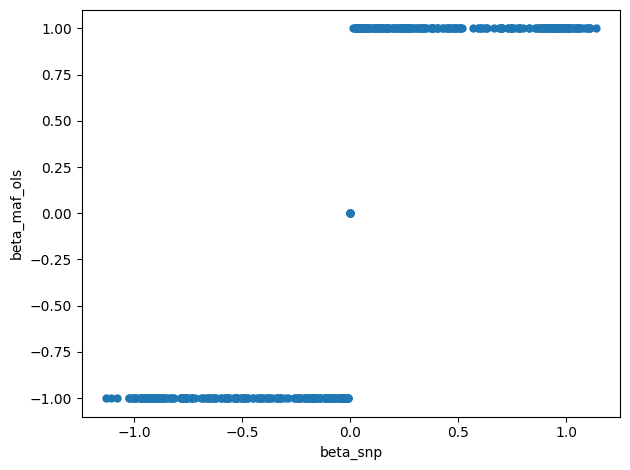

In [26]:
sns.scatterplot(x='beta_snp', y='beta_maf_ols',data=to_compare, linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

# Met causal snp

In [49]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

def multi(arr, effectsize):
    return [num * effectsize for num in arr]

In [50]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in complete.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in complete.columns if '_AF_' in col]

beta_values = multi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
betas = pd.DataFrame(data)

In [51]:
#betas['Beta'] = betas['Beta']/betas['Beta'].max()

In [52]:
betas['Beta']

0      0.4225
1      0.2925
2      0.4475
3      0.2275
4      0.4425
        ...  
420    0.0450
421    0.0325
422    0.0475
423    0.0475
424    0.0275
Name: Beta, Length: 425, dtype: float64

In [53]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 1
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [54]:
humans['pheno'] = phenos_mono[snp]
PC_complete['pheno'] = phenos_mono[snp]

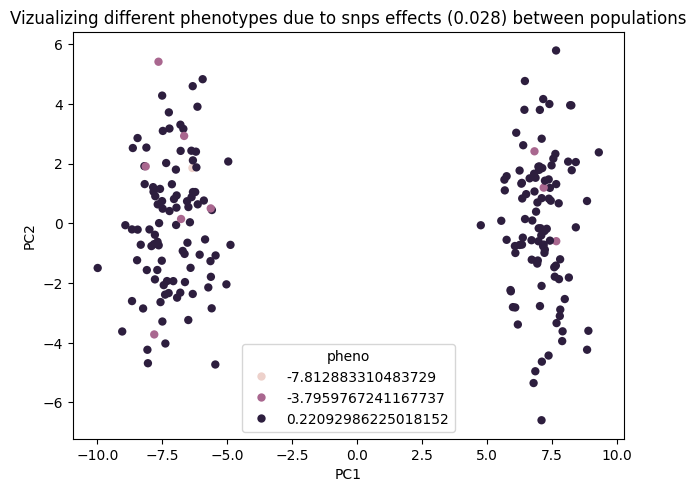

In [55]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'pheno', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

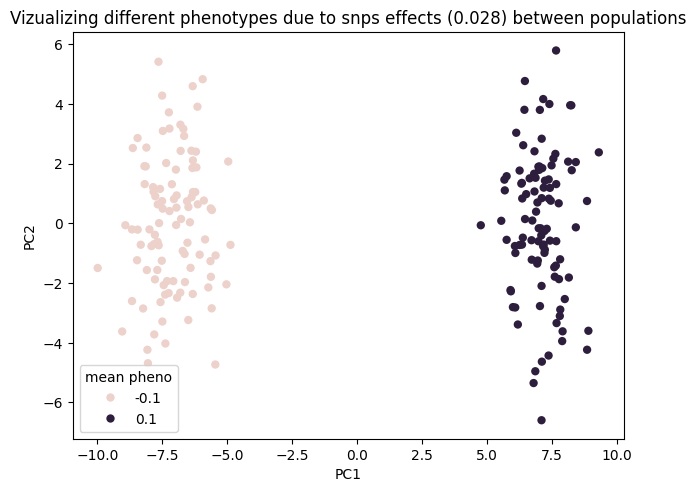

In [56]:
mean_snp_effect_per_pop = np.round(PC_complete.groupby('populations')['pheno'].transform('mean'),3)

# Add the calculated mean as a new column
PC_complete['mean pheno'] = mean_snp_effect_per_pop

sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mean pheno', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

# Calculating betas

In [57]:
betas

,snp,Beta
0,CG3,0.4225
1,CG4,0.2925
2,CG5,0.4475
3,CG6,0.2275
4,CG7,0.4425
...,...,...
420,VRG147,0.0450
421,VRG184,0.0325
422,VRG198,0.0475
423,VRG371,0.0475


In [58]:
snp

'VRG423_AF_0.0275'

In [68]:
total_pop = len(complete)
val_minor = -1
val_het = 0
val_major = 1
betas_mafs_manually = []
betas_mafs_ols = []
logP_mafs_ols = []
betas_snps = []
logP_snps = []
true_betas = []
for snp in complete.columns:
    beta_value = betas.loc[betas['snp'] == snp.split('_AF_')[0], 'Beta'].values[0]
    true_betas.append(beta_value)
    humans['snp'] = complete[snp]
    humans['pheno'] = phenos_mono[snp]
    
    #humans['pheno'] = min_max_scaling(humans['pheno'],0,1)
    mean_risk_per_pop = {}
    nr_people_per_pop = {}
    maj_afs = {}
    min_afs = {}
    het_afs = {}
    total_nr_peeps = 0
    mean_global_risk = 0

    X_from_mafs = []
    Y_from_mafs = []
    for unique_pop in humans.populations.unique():
        temp = humans[humans['populations'] == unique_pop]
        nr_humans_pop = len(temp)
    
        total_alleles = len(temp['snp'])  # Total number of alleles (2 alleles per sample)
        q2_freq = (temp['snp'].value_counts().get(val_minor, 0))/total_alleles
        pq_freq = (temp['snp'].value_counts().get(val_het, 0))/total_alleles
        p2_freq = (temp['snp'].value_counts().get(val_major, 0))/total_alleles

        X = val_minor*q2_freq + val_het*pq_freq + val_major*p2_freq
        X_from_mafs.append(X*(nr_humans_pop**2/total_pop))
        Y_from_mafs.append(temp['pheno'].mean())

    X = min_max_scaling(X_from_mafs,-1,1)
    #X=np.array(X_from_mafs)
    Y = np.array(Y_from_mafs)
    
    n = len(X)
    sum_X = np.sum(X)
    sum_Y = np.sum(Y)
    sum_XY = np.sum(X * Y)
    sum_X_squared = np.sum(X**2)
    betas_mafs_manually.append((n * sum_XY - sum_X * sum_Y) / (n * sum_X_squared - sum_X**2))

    beta_snps = manhattan_linear(complete[[snp]], humans[['pheno']])
    beta_mafs_ols = manhattan_linear(maf_df[[snp]], humans[['pheno']])
    
    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

IndexError: list index out of range

In [ ]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['-logP_snp'] = logP_snps
to_compare['beta_maf_manual'] = betas_mafs_manually
to_compare['beta_maf_ols'] = betas_mafs_ols
to_compare['-logP_maf_ols'] = logP_mafs_ols
to_compare['true_betas'] = true_betas


In [ ]:
sns.scatterplot(x='true_betas', y='beta_snp',data=to_compare, linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

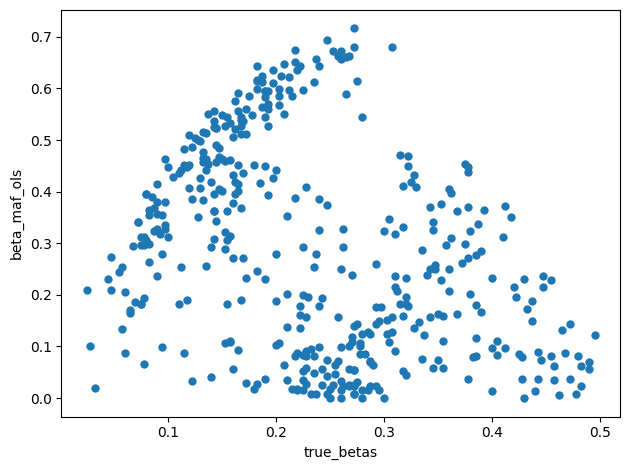

In [66]:
sns.scatterplot(x='true_betas', y='beta_maf_ols',data=to_compare, linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()